### Requirements

In [4]:
# base
import sys
import json
#cleaning
import re
import unicodedata
#manupulate numbers
import numpy as np
import pandas as pd
import random
from scipy.stats import (
    uniform,
    randint
)
#grphs
import matplotlib.pyplot     as plt
import seaborn               as sns
#gcp
sys.path.append('..')
from settings import Settings
settings = Settings()
from clients.google import Gcp
gcp = Gcp(settings.EMBBEDINGS_BUCKET)
#modeling
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
#ensamble
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier
)
import xgboost as xgb
#store
import pickle


# data

In [5]:
files = [
    'usem/1697445298_embedded_reviews_train.npz',
    'usem/1697445298_embedded_reviews_test.npz'
    ]

{'X_train': ['Payment Analyst',
  'Senior Account Manager',
  'City Manager Barranquilla',
  'analista comunicaciones internas',
  'gerente cuentas corporativas',
  'qa automatizador',
  'analista junior nomina',
  'TODERO DE ASEO Y MANTENIMIENTO',
  'Customer Experience  / Strategic Designer',
  'agente operativo',
  'director administrativo',
  'desarrollador frontend developer react semi senior',
  'lider de tienda cartagena septiembre',
  ' hrops analyst',
  'asistente tpm',
  'coordinador operaciones ',
  'Desarrollador .NET Semi-Senior',
  'Performance Marketer',
  'Televendedor',
  'marketing manager bb',
  'asesores gerentes reclutadores',
  'Product owner ',
  'regional sales coordinator',
  'Co-Founder/COO',
  'hunter comercial ',
  'desarrollador fullstack react node js',
  'Sr Finance Manager',
  'Directo Of Data Platform',
  'supervisor ',
  'backend enginner sr',
  'Jr. Fullstack Software Developer ',
  'Tecnico Analista control de calidad',
  'cobranza',
  'copy comunity

In [3]:
df = gcp.read_np_from_gcs(files[0], allow_pickle=True)
if df is not None and len(df) > 0:
    df_train = (
        pd.DataFrame({x: df[x] for x in df})
        .rename(columns={"index": "id"})
        .set_index("id")
    )
df = gcp.read_np_from_gcs(files[1], allow_pickle=True)
if df is not None and len(df) > 0:
    df_test = (
        pd.DataFrame({x: df[x] for x in df})
        .rename(columns={"index": "id"})
        .set_index("id")
    )
os.remove("file.npz")

In [6]:
df_train.columns

,x_train,y_train
0,Payment Analyst,Finanzas y Contabilidad
1,Senior Account Manager,Ventas Comercial
2,City Manager Barranquilla,Ventas Comercial
3,analista comunicaciones internas,Mercadeo
4,gerente cuentas corporativas,Ventas Comercial
...,...,...
7994,diseñador ux-ui,Diseño
7995,front desk position,Otros
7996,Fundraising Manager,Finanzas y Contabilidad
7997,digital marketing specialist web growth fully ...,Mercadeo


In [7]:
df_train

,x_test,y_test
0,Comprador - Categoría de no alimentos,Operaciones Logística
1,sme sales specialist growing regions,Ventas Comercial
2,controlling anlyst,Finanzas y Contabilidad
3,lider formacion tecnica,Tecnología
4,analista qa junior,Tecnología
...,...,...
3424,auxiliar repuestos funza,Otros
3425,kam restaurantes reynosa,Ventas Comercial
3426,DESARROLLADOR WEB PHP SEMI-SENIOR BILINGUE REMOTO,Tecnología
3427,sales account executive ejecutivo comercial,Ventas Comercial


In [ ]:
len(df_train.embedded_review.values[0])

In [ ]:
len(df_train.y.values[0])

In [ ]:
df_test.columns

In [ ]:
df_test

In [ ]:
len(df_test.embedded_review.values[0])

In [ ]:
len(df_test.y.values[0])

# Sampling

In [21]:
X_train = np.array(list(df_train['embedded_review']))
X_test = np.array(list(df_test['embedded_review']))
y_train = np.array(list(df_train['y']))
y_test = np.array(list(df_test['y']))

In [22]:
print(
    len(X_test),
    len(X_train),
    len(y_test),
    len(y_train))

3152 6635 3152 6635


# Modeling

## Xgboost

In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob")

In [ ]:
%%time
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    random_state=42,
    n_iter=200,
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)


CPU times: user 2.62 ms, sys: 0 ns, total: 2.62 ms
Wall time: 2.63 ms


In [ ]:
%%time
search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: user 8min 37s, sys: 361 ms, total: 8min 38s
Wall time: 6h 3min 43s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd30842eca0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd30842eaf0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fd308616df0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fd30842ee80>},
                   random_state=42, return_train_score=True, verbose=1)

In [ ]:
%%time
search.cv_results_

{'mean_fit_time': array([157.90518937, 391.7564682 , 171.83745103, 355.15627012,
        437.37418904, 466.72555075, 216.91207891, 310.80033245,
        404.06655068, 198.57672367, 398.20151682, 425.95278378,
        492.81977406, 314.1200634 , 375.48794446, 304.30954332,
        517.7410943 , 262.94860482, 411.07418308, 430.91006427,
        356.23676658, 481.0495153 , 455.84827399, 360.84121103,
        232.01919446, 147.31560912, 476.26508541, 300.04880762,
        149.28330994, 255.99327526, 311.75565391, 218.45142307,
        399.01748157, 309.008918  , 457.61998878, 420.01321096,
        189.44862456, 253.66510282, 345.98461504, 337.56985288,
        318.47984538, 495.57906771, 279.13075776, 353.49170594,
        418.80405068, 479.92240791, 490.11891336, 554.29199376,
        364.21865277, 322.70469451, 410.32179103, 378.22744966,
        307.32782378, 513.06957717, 259.61671896, 329.72271085,
        292.3339921 , 259.84229455, 367.54816208, 210.52753739,
        263.1919486 , 1

In [ ]:
results = search.cv_results_

In [ ]:
for i in range(1, 5 + 1):
      candidates = np.flatnonzero(results['rank_test_score'] == i)
      for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Model with rank: 1
Mean validation score: 0.732 (std: 0.007)
Parameters: {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}

Model with rank: 2
Mean validation score: 0.731 (std: 0.005)
Parameters: {'colsample_bytree': 0.9486212527455787, 'gamma': 0.17837666334679464, 'learning_rate': 0.11428035290621423, 'max_depth': 5, 'n_estimators': 144, 'subsample': 0.6563696899899051}

Model with rank: 3
Mean validation score: 0.731 (std: 0.010)
Parameters: {'colsample_bytree': 0.7587948587257435, 'gamma': 0.022613644455269033, 'learning_rate': 0.1275990992289793, 'max_depth': 5, 'n_estimators': 144, 'subsample': 0.7085396127095583}

Model with rank: 3
Mean validation score: 0.731 (std: 0.007)
Parameters: {'colsample_bytree': 0.7762490947209216, 'gamma': 0.14764529420946937, 'learning_rate': 0.12676522927158015, 'max_depth': 5, 'n_estimators': 132, 'subsample': 0.6546485

In [ ]:
search.best_params_

{'colsample_bytree': 0.7467983561008608,
 'gamma': 0.02904180608409973,
 'learning_rate': 0.28985284373248055,
 'max_depth': 5,
 'n_estimators': 139,
 'subsample': 0.8832290311184181}

In [ ]:
search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7467983561008608, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.02904180608409973, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.28985284373248055, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=139, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_hat_xgb = search.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, y_hat_xgb))

Accuracy score: 0.7576142131979695


In [ ]:
values = list(dict_ctl.values())
CM = pd.DataFrame(confusion_matrix(y_test, y_hat_xgb), columns=values)
#CM['Total_Real'] = CM.sum(axis=1)
#CM = CM.append(CM.sum(axis=0), ignore_index=True)
#CM.index = list(dict_ctl.values()) + ['Total_Predicción']
print(CM)

     0    1    2    3    4    5   6   7    8
0  489   26    0   26    4   17   3   0   51
1   33  246    4    7    0    8   6   8   31
2    2    1  177    6    2    4   0   0   13
3   29    8    2  239    4   18   4   2   45
4   11    5    2    4  140    4   2   0   17
5   10    7    2    7    2  679   6   0   43
6    8    3    1    7    2   17  65   0   16
7    1    2    0    0    0    3   2  70   11
8   47   16    9   41   14   64   8   6  283


Text(0.5, 1.0, 'Confusion Matrix Ariel v2')

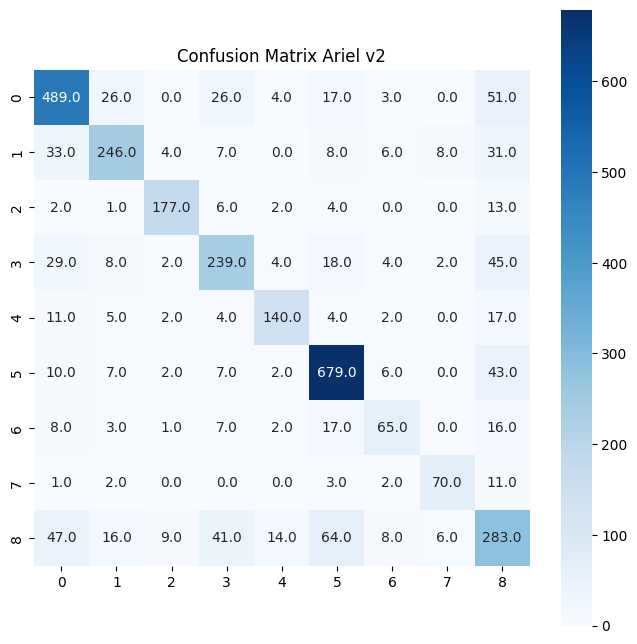

In [ ]:
# Draw the heatmap with the mask and correct aspect ratio
#sns.set(font_scale=2)
#plt.style.use("dark_background")
plt.figure(figsize= (8,8))
sns.heatmap(CM, cmap="Blues",#"RdYlBu",#"YlOrBr", 
    annot=True, square=True,
    #vmin=-1, vmax=1,
    #fmt="+.1f"
    fmt=".1f")
plt.title("Confusion Matrix Ariel v2")

In [ ]:
print(classification_report(y_test, y_hat_xgb))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       616
           1       0.78      0.72      0.75       343
           2       0.90      0.86      0.88       205
           3       0.71      0.68      0.69       351
           4       0.83      0.76      0.79       185
           5       0.83      0.90      0.86       756
           6       0.68      0.55      0.60       119
           7       0.81      0.79      0.80        89
           8       0.55      0.58      0.57       488

    accuracy                           0.76      3152
   macro avg       0.76      0.74      0.75      3152
weighted avg       0.76      0.76      0.76      3152



## saving pickle module

In [ ]:
#pkl_filename = "/datasets/bubblejobrecommendationsdata/models/ariel_xgb.pkl"
pathfile = '/work/ariel/models/ariel_xgb.pkl'
pickle.dump(search.best_estimator_, open(pathfile, "wb"))

## Validation

In [2]:
#pkl_filename = "/datasets/bubblejobrecommendationsdata/models/ariel_xgb.pkl"
pkl_filename = '/work/ariel/models/ariel_xgb.pkl'
with open(pkl_filename, 'rb') as file:
    ariel = pickle.load(file)

In [23]:
#Calculate the accuracy score and predict target values
score = ariel.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Y_predict = ariel.predict(X_test)

Test score: 75.76 %


In [27]:
prob = ariel.predict_proba(X_test)
prob[0]

array([1.4960377e-02, 4.9229950e-02, 5.0134066e-04, 1.4069814e-02,
       1.2495446e-03, 5.9559512e-01, 7.9659531e-03, 2.0946507e-01,
       1.0696286e-01], dtype=float32)

In [33]:
Y_predict[10]

3

In [36]:
[np.argmax(item) for item in prob]
[max(item) for item in prob]

[0.5955951,
 0.7220877,
 0.8738365,
 0.999668,
 0.7691873,
 0.9962404,
 0.5667575,
 0.47765628,
 0.7329424,
 0.9471211,
 0.5341618,
 0.95007473,
 0.995122,
 0.9944377,
 0.96487814,
 0.8727881,
 0.9806538,
 0.51101875,
 0.93154734,
 0.719928,
 0.71709293,
 0.99515307,
 0.42743924,
 0.8368207,
 0.98297,
 0.9870221,
 0.99674064,
 0.98767835,
 0.99373454,
 0.84883845,
 0.97937334,
 0.98188835,
 0.99799687,
 0.9924765,
 0.388545,
 0.98941016,
 0.90302664,
 0.9994764,
 0.9940619,
 0.92068523,
 0.9978416,
 0.9749518,
 0.9729874,
 0.9474974,
 0.63232833,
 0.6967561,
 0.4954882,
 0.97543937,
 0.50096464,
 0.48230538,
 0.7999591,
 0.99048597,
 0.86433154,
 0.9316094,
 0.5566477,
 0.9089069,
 0.8057526,
 0.73080105,
 0.9916802,
 0.95731807,
 0.99201524,
 0.9848748,
 0.96164066,
 0.9998715,
 0.8497026,
 0.9927273,
 0.9443442,
 0.9838012,
 0.40411642,
 0.8597273,
 0.7533081,
 0.645365,
 0.98567015,
 0.71611935,
 0.9180411,
 0.61873835,
 0.95805657,
 0.981952,
 0.8505853,
 0.41274092,
 0.6474974,
 0

In [ ]:
values = list(dict_ctl.values())
CM = pd.DataFrame(confusion_matrix(y_test, Y_predict), columns=values)
#CM['Total_Real'] = CM.sum(axis=1)
#CM = CM.append(CM.sum(axis=0), ignore_index=True)
#CM.index = list(dict_ctl.values()) + ['Total_Predicción']
print(CM)

     0    1    2    3    4    5   6   7    8
0  489   26    0   26    4   17   3   0   51
1   33  246    4    7    0    8   6   8   31
2    2    1  177    6    2    4   0   0   13
3   29    8    2  239    4   18   4   2   45
4   11    5    2    4  140    4   2   0   17
5   10    7    2    7    2  679   6   0   43
6    8    3    1    7    2   17  65   0   16
7    1    2    0    0    0    3   2  70   11
8   47   16    9   41   14   64   8   6  283


Text(0.5, 1.0, 'Confusion Matrix Ariel v2')

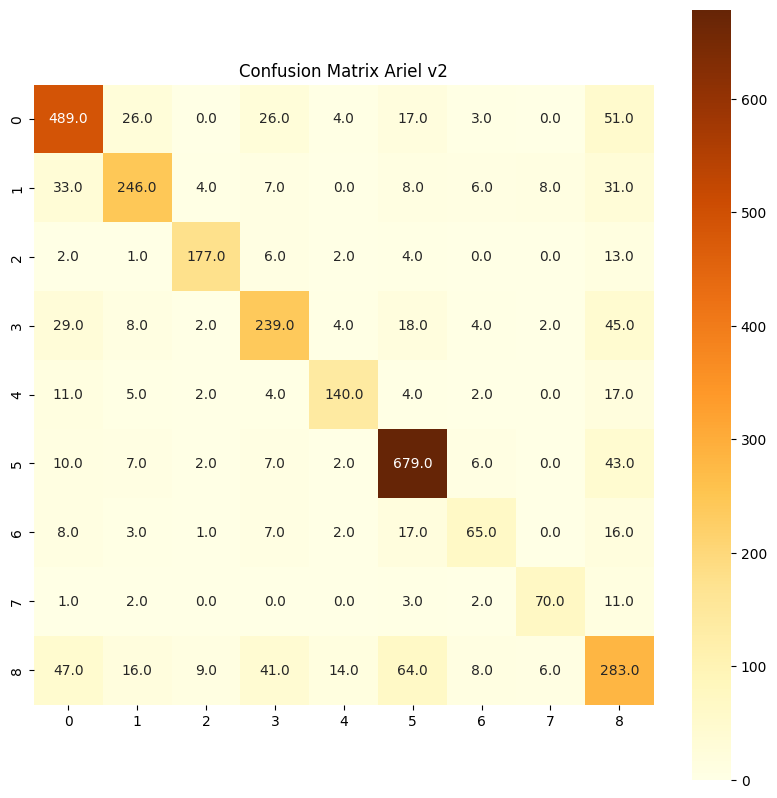

In [ ]:
# Draw the heatmap with the mask and correct aspect ratio
#sns.set(font_scale=2)
#plt.style.use("dark_background")
plt.figure(figsize= (10,10))
sns.heatmap(CM, cmap="YlOrBr",#"Blues",#"YlOrBr", 
    annot=True, square=True,
    #vmin=-1, vmax=1,
    #fmt="+.1f"
    fmt=".1f")
plt.title("Confusion Matrix Ariel v2")

In [ ]:
print(classification_report(y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       616
           1       0.78      0.72      0.75       343
           2       0.90      0.86      0.88       205
           3       0.71      0.68      0.69       351
           4       0.83      0.76      0.79       185
           5       0.83      0.90      0.86       756
           6       0.68      0.55      0.60       119
           7       0.81      0.79      0.80        89
           8       0.55      0.58      0.57       488

    accuracy                           0.76      3152
   macro avg       0.76      0.74      0.75      3152
weighted avg       0.76      0.76      0.76      3152



In [ ]:
unlabels = {v : k for k,v in dict_ctl.items()}
unlabels

{0: 'Ventas Comercial',
 1: 'Mercadeo',
 2: 'Recursos Humanos',
 3: 'Operaciones Logística',
 4: 'Finanzas y Contabilidad',
 5: 'Tecnología',
 6: 'Gerencia de Proyectos Consultoria',
 7: 'Diseño',
 8: 'Otros'}

In [ ]:
%%time
cargo = ['community manager']
unlabels[search.predict(api_embeddings(embedding_api_endpoint, cargo))[0]]

CPU times: user 12.7 ms, sys: 1e+03 ns, total: 12.7 ms
Wall time: 35.6 s


'Mercadeo'

In [ ]:
%%time
cargo = ['data head']
unlabels[ariel.predict(api_embeddings(embedding_api_endpoint, cargo))[0]]

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 109 ms


'Tecnología'

In [ ]:
ariel.predict(api_embeddings(embedding_api_endpoint, cargo)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=864bd4e6-ab11-4b7e-9f69-8effd1ca5bf3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>